In [2]:
import sklearn.covariance
import torch
from collections import defaultdict
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import detectors
import time


/Users/dadalto/github/detectors/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
NOTE: Redirects are currently not supported in Windows or MacOs.


In [3]:
sample_size = 500
d = 512

cov rank: 499/512
cov determinant: 0.0


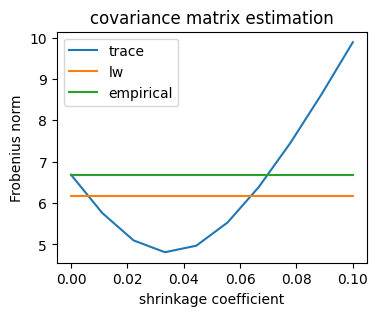

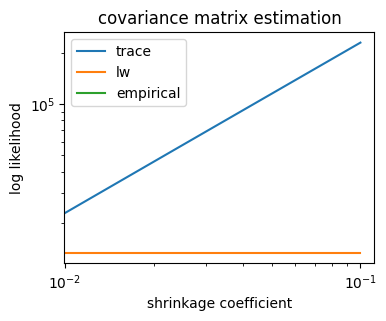

In [4]:
true_cov = np.random.uniform(0, 1, (d, d)) #+ np.eye(d)*10
true_cov = true_cov @ true_cov.T / d
true_inv = np.linalg.inv(true_cov)
true_mean = np.random.uniform(0, 1, d)
X = np.random.multivariate_normal(true_mean, true_cov, sample_size)

emp_cov = sklearn.covariance.empirical_covariance(X)
loglik = -sklearn.covariance.log_likelihood(emp_cov, np.linalg.inv(true_cov))
cov_rank = np.linalg.matrix_rank(emp_cov)
print(f"cov rank: {cov_rank}/{d}")
print(f"cov determinant: {np.linalg.det(emp_cov)}")
coeffs = np.linspace(0, 0.1, 10)

Sigmas = defaultdict(list)
for shrinkage_coeff in coeffs:
    Sigmas["trace"].append((1-shrinkage_coeff) * emp_cov + shrinkage_coeff * np.eye(d) * np.trace(emp_cov) / d)
    # Sigmas["diag"].append((1-shrinkage_coeff) * emp_cov + shrinkage_coeff * np.eye(d) * np.diag(emp_cov))
    Sigmas["lw"].append(sklearn.covariance.ledoit_wolf(X)[0])


logliks = defaultdict(list)
for k in Sigmas.keys():
    for v in Sigmas[k]:
        logliks[k].append(-sklearn.covariance.log_likelihood(v, true_inv))

# frobenius norm
norms = defaultdict(list)
for k in Sigmas.keys():
    for v in Sigmas[k]:
        norms[k].append(np.linalg.norm(v - true_cov, ord='fro'))

cov_norm = np.linalg.norm(emp_cov - true_cov, ord='fro')

plt.figure(figsize=(4,3))
for k, v in norms.items():
    plt.plot(coeffs, v, label=k)
plt.plot(coeffs, [cov_norm] * len(coeffs), label='empirical')
plt.ylabel('Frobenius norm')
plt.xlabel('shrinkage coefficient')
plt.title('covariance matrix estimation')
plt.legend()
plt.show()

plt.figure(figsize=(4,3))
for k, v in logliks.items():
    plt.loglog(coeffs, v, label=k)
plt.loglog(coeffs, [loglik] * len(coeffs), label='empirical')
plt.ylabel('log likelihood')
plt.xlabel('shrinkage coefficient')
plt.title('covariance matrix estimation')
plt.legend()
plt.show()

sample size: 1000, time: 0.03 s, loglik: -327.12
sample size: 10000, time: 0.35 s, loglik: -327.75
sample size: 100000, time: 2.18 s, loglik: -327.67
sample size: 1000000, time: 96.03 s, loglik: -327.71


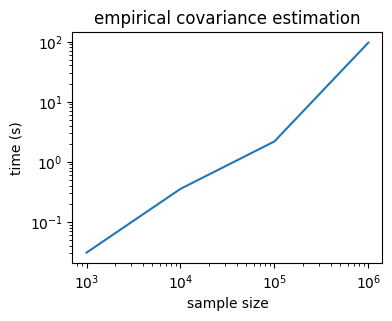

In [5]:
# time comparison
d = 1024
true_cov = np.random.uniform(0, 1, (d, d)) #+ np.eye(d)*10
true_cov = true_cov @ true_cov.T / d
true_inv = np.linalg.inv(true_cov)
true_mean = np.random.uniform(0, 1, d)
times = {}
for n in [1000, 10_000, 100_000, 1_000_000]:
    X = np.random.multivariate_normal(true_mean, true_cov, n)
    t0 = time.time()
    emp_cov = sklearn.covariance.empirical_covariance(X)
    t1 = time.time()
    loglik = -sklearn.covariance.log_likelihood(emp_cov, np.linalg.inv(true_cov))
    times[n]=t1-t0
    print(f"sample size: {n}, time: {t1-t0:.2f} s, loglik: {loglik:.2f}")
  
plt.figure(figsize=(4,3))
plt.loglog(times.keys(), times.values())
plt.ylabel('time (s)')
plt.xlabel('sample size')
plt.title('empirical covariance estimation')
plt.show()

In [12]:
# cholesky decomposition
a = torch.randn(3, 3)
a = a @ a.T
print(a)
l = torch.cholesky(a)
z = l @ l.mT
print(z)
torch.dist(a, z)

tensor([[ 4.3296, -0.1891,  0.1118],
        [-0.1891,  0.2759, -0.7559],
        [ 0.1118, -0.7559,  2.1924]])
tensor([[ 4.3296, -0.1891,  0.1118],
        [-0.1891,  0.2759, -0.7559],
        [ 0.1118, -0.7559,  2.1924]])


tensor(5.3395e-07)

In [71]:
X = torch.randn(320, 2048)
X = X - X.mean(0)
m = X.T @ X
cov_reg = m.trace()* 1e-6#* 0
m = m + cov_reg * torch.eye(m.shape[0])
print(cov_reg)
print("shape m", m.shape)
print("trace m", m.trace())
print("det", torch.linalg.det(m))
ll = torch.cholesky(m)
print("dist cholesky", torch.dist(m, ll @ ll.mT))
u,s,v = torch.svd(m)
msvd = torch.mm(torch.mm(u, torch.diag(s)), v.t())
print("dist svd", torch.dist(m, msvd))

tensor(0.6524)
shape m torch.Size([2048, 2048])
trace m tensor(653686.3750)
det tensor(inf)
dist cholesky tensor(0.0264)
dist svd tensor(0.1202)


: 